In [102]:
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

True

In [103]:
import os
openai_key = os.getenv("OPENAI_API_KEY")
openai_api_base = os.getenv("OPENAI_API_BASE")
openai_api_version = "2025-01-01-preview"
model = "gpt-4.1"

In [104]:
from langchain.chat_models import AzureChatOpenAI

llm = AzureChatOpenAI(
    openai_api_key=openai_key,
    openai_api_base=openai_api_base,
    deployment_name=model,
    openai_api_version=openai_api_version,  # Or your specific version
    # temperature=0.0,
    # max_tokens=1000,
    # max_retries=3
)

/home/skundu/Documents/MY_PROJECT/ai/venv/lib/python3.12/site-packages/langchain_community/chat_models/azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://optra-kolkata-openai.openai.azure.com/ to https://optra-kolkata-openai.openai.azure.com/openai.
  warnings.warn(
/home/skundu/Documents/MY_PROJECT/ai/venv/lib/python3.12/site-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(
/home/skundu/Documents/MY_PROJECT/ai/venv/lib/python3.12/site-packages/langchain_community/chat_models/azure_openai.py:189: UserWarning: As of openai>=1.0.0, if `openai_api_base` (or alias `base_u

In [105]:
# Example usage of the llm
llm.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm just a bunch of code, but I'm ready to help you. How are you?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 13, 'total_tokens': 34, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b663f05c2c', 'finish_reason': 'stop', 'logprobs': None}, id='run--b36cd99b-f757-4980-ab55-39a81943efff-0')

In [120]:
from langchain_core.tools import tool

@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 300.0,
        "AAPL": 150.0,
        "AMZN": 3500.0,
        "TSLA": 800.0,
        "META": 350.0,
        "GOOGL": 2800.0
    }.get(symbol, 0.0)

tools = [get_stock_price]
llm_with_tools = llm.bind(tools=tools,
                            tool_choice="auto",
                            tool_choice_kwargs={"max_retries": 3},
                            tool_choice_timeout=5,
                            tool_choice_max_tokens=1000)
# llm_with_tools = llm.bind_tools(tools)

In [122]:
print(type(llm))
print(type(llm_with_tools))
llm_with_tools.invoke("input=\"Hello, how are you?\"")

<class 'langchain_community.chat_models.azure_openai.AzureChatOpenAI'>
<class 'langchain_core.runnables.base.RunnableBinding'>


TypeError: Completions.create() got an unexpected keyword argument 'tool_choice_kwargs'

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from pydantic import BaseModel
from typing import List, Dict
# class State(BaseModel):
#     messages: List[Dict[str, str]] 
    
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State) -> State:
    """
    A simple chatbot function that invokes the LLM with the current state messages.
    """
    return {"messages": [llm.invoke(state["messages"])]}  # Assuming state["messages"] is a list of messages

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

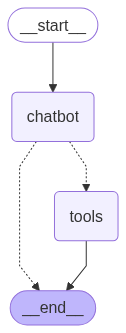

In [ ]:
# pip install graphviz
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = {
            "role": "user",
            "content": "whats the price of AAPL?",
            }
response = graph.invoke({"messages": [messages]}) 
response['messages']

[HumanMessage(content='whats the price of AAPL?', additional_kwargs={}, response_metadata={}, id='8967966a-2035-4b37-89c9-d559a69e8eda'),
 AIMessage(content="I don't have access to real-time data. To get the current price of AAPL (Apple Inc.), please check a reliable financial news website, a stock trading app, or a financial data provider like Yahoo Finance, Google Finance, or Bloomberg. If you have another question about Apple or stocks in general, feel free to ask!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 15, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b663f05c2c', 'finish_reason': 'stop', 'logprobs': None}, id='run--bb0df525-12d5-4e1c-8b08-f597b0480c10-0')]

In [ ]:
state = None
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit", "stop", "x", "q"]:
        print("Goodbye!")
        break
    messages = {
        "role": "user",
        "content": user_input,
    } 
    
    if state is None:
        state : State = {
            "messages": [messages]
        }
    else:
        state["messages"].append(messages)
    
    state = graph.invoke(state)
    bot_response = state['messages'][-1].content
    print("state: ",state['messages'])
    print(f"YOU: {user_input}")
    print(f"BOT: {bot_response}")

PydanticSerializationError: Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>